<a href="https://colab.research.google.com/github/ptaceda/mrtva_doba_VU/blob/main/zpracovani_vysledku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
### SPUSTIT TOHLE NA PC PŘED PRACÍ !!

import os
import sys

# Set the working directory to the project directory
device = input("Zadej prosím, na jakém zařízení děláš (mac/doma/prace): ")
if device == "doma":
    project_dir = r"C:/Users/danie/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
elif device == "mac":
    project_dir = r"/Users/danielptacek/Desktop/mrtva_doba_VU"
    os.chdir(project_dir)
else:
    project_dir = r"U:/Dokumenty/mrtva_doba_VU"
    os.chdir(project_dir)


# Verify the change
print("Current working directory:", os.getcwd()) 

# Ensure the project directory is in sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

import pydicom # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import os
from glob import glob
import sys

from codes.custom_library import Graf_1_2

aktivity = {
    "20240708" : 700.589,
    "20240709" : 640.979,
    "20240710" : 586.294,
    "20240711" : 537.692,
    "20240712" : 495.958,
    "20240714" : 404.370,
    "20240715" : 379.365,
    "20240717" : 324.319,
    "20240719" : 266.596,
    "20240721" : 226.576,
    "20240723" : 190.942,
    "20240725" : 158.536,
    "20240726" : 152.496,
    "20240729" : 115.038,
    "20240731" : 93.633,
    "20240805" : 62.613,
    "20240808" : 49.233,
    "20240812" : 34.167
}


Current working directory: /Users/danielptacek/Desktop/mrtva_doba_VU


In [ ]:
## OPTIMA prvotni DATA
optima_folder = 'Optima'

optima_mds = glob(os.path.join(optima_folder, 'MD*'))

for md in optima_mds:
    text_file_path = os.path.join(md, 'vysledky.txt')
    with open(text_file_path, 'w+') as file:
        file.write('Typ_Datum_Kamera    Hlava_okno   Count_rate\n')

    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]
    data_paths = [dead_time_path, pozadi_path]
    
    dt_data = pydicom.dcmread(dead_time_path)
    pozadi_data = pydicom.dcmread(pozadi_path)
    datas = [dt_data, pozadi_data]

    for dicom_data, path in zip(datas, data_paths):
        # Get the base filename without extension
        base_filename = os.path.basename(path)
        filename_without_extension = os.path.splitext(base_filename)[0]

        # Access the custom group containing Dataset Names and print them
        if (0x0011, 0x1012) in dicom_data:
            dataset_names = dicom_data[0x0011, 0x1012].value
            dataset_acq_time = dicom_data[0x0018, 0x1242].value*0.001

            # Extract the pixel array from the DICOM data
            if 'PixelData' in dicom_data:
                pixel_array = dicom_data.pixel_array

                # Check if the pixel array has the expected number of slices
                num_slices = pixel_array.shape[0]
                if num_slices != len(dataset_names):
                    print("Warning: Number of slices does not match the number of dataset names.")

                # Create a figure and a 2x3 grid of subplots
                fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi = 200)
                
                # Flatten the axes array for easy iteration
                axes = axes.flatten()

                # Separate the indices of "Head1" and "Head2" datasets
                head1_indices = [i for i, name in enumerate(dataset_names) if "Head1" in name]
                head2_indices = [i for i, name in enumerate(dataset_names) if "Head2" in name]

                head1_dict = {}
                head2_dict = {}

                # Loop through each "Head1" slice and plot it in the first row
                for idx, head1_idx in enumerate(head1_indices):
                    ax = axes[idx]
                    ax.imshow(pixel_array[head1_idx], cmap='gray')
                    ax.set_title(dataset_names[head1_idx])
                    ax.axis('off')  # Hide the axes ticks

                    # Calculate and print the sum of pixel values
                    pixel_sum = pixel_array[head1_idx].sum()
                    count_rate = pixel_sum / dataset_acq_time
                    with open(text_file_path, 'a+') as file:
                        file.write(f"{filename_without_extension}   {dataset_names[head1_idx]}   {round(count_rate,2)}\n")

                # Loop through each "Head2" slice and plot it in the second row
                for idx, head2_idx in enumerate(head2_indices):
                    ax = axes[idx + 3]
                    ax.imshow(pixel_array[head2_idx], cmap='gray')
                    ax.set_title(dataset_names[head2_idx])
                    ax.axis('off')  # Hide the axes ticks

                    # Calculate and print the sum of pixel values
                    pixel_sum = pixel_array[head2_idx].sum()
                    count_rate = pixel_sum / dataset_acq_time
                    with open(text_file_path, 'a+') as file:
                        file.write(f"{filename_without_extension}   {dataset_names[head2_idx]}  {round(count_rate,2)}\n")

                # Adjust layout to avoid overlap
                fig.savefig(os.path.join(md, f'{filename_without_extension}.jpg'), bbox_inches='tight')
                plt.close()
            else:
                print("No image data found in the DICOM file.")
        else:
            print("The DICOM file does not contain the expected custom group with dataset names.")
    



    

In [ ]:
## DISCOVERY prvotni DATA
discovery_folder = 'Discovery'
a = 3

discovery_mds = glob(os.path.join(discovery_folder, 'MD*'))

for md in discovery_mds:
    text_file_path = os.path.join(md, 'vysledky.txt')
    with open(text_file_path, 'w+') as file:
        file.write('Vysledky mereni mrtve doby:\n')
        file.write('Typ_Datum_kamera    Hlava_okno  Pocet_akum_impulsu  Acq_time  Count_rate\n')

    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]
    data_paths = [dead_time_path, pozadi_path]
    
    dt_data = pydicom.dcmread(dead_time_path)
    pozadi_data = pydicom.dcmread(pozadi_path)
    datas = [dt_data, pozadi_data]

    for dicom_data, path in zip(datas, data_paths):
        # Get the base filename without extension
        base_filename = os.path.basename(path)
        filename_without_extension = os.path.splitext(base_filename)[0]

        # Access the custom group containing Dataset Names and print them
        if (0x0011, 0x1012) in dicom_data:
            dataset_names = dicom_data[0x0011, 0x1012].value
            dataset_acq_time = dicom_data[0x0018, 0x1242].value*0.001

            # Extract the pixel array from the DICOM data
            if 'PixelData' in dicom_data:
                pixel_array = dicom_data.pixel_array

                # Check if the pixel array has the expected number of slices
                num_slices = pixel_array.shape[0]
                if num_slices != len(dataset_names):
                    print("Warning: Number of slices does not match the number of dataset names.")

                # Create a figure and a 2x3 grid of subplots
                fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi = 200)
                
                # Flatten the axes array for easy iteration
                axes = axes.flatten()

                # Separate the indices of "Head1" and "Head2" datasets
                head1_indices = [i for i, name in enumerate(dataset_names) if "Head1" in name]
                head2_indices = [i for i, name in enumerate(dataset_names) if "Head2" in name]

                # Loop through each "Head1" slice and plot it in the first row
                for idx, head1_idx in enumerate(head1_indices):
                    ax = axes[idx]
                    ax.imshow(pixel_array[head1_idx], cmap='gray')
                    ax.set_title(dataset_names[head1_idx])
                    ax.axis('off')  # Hide the axes ticks

                    # Calculate and print the sum of pixel values
                    pixel_sum = pixel_array[head1_idx].sum()
                    count_rate = pixel_sum / dataset_acq_time
                    with open(text_file_path, 'a+') as file:
                        file.write(f"{filename_without_extension}   {dataset_names[head1_idx]}  {pixel_sum} {dataset_acq_time} {round(count_rate,2)}\n")

                # Loop through each "Head2" slice and plot it in the second row
                for idx, head2_idx in enumerate(head2_indices):
                    ax = axes[idx + 3]
                    ax.imshow(pixel_array[head2_idx], cmap='gray')
                    ax.set_title(dataset_names[head2_idx])
                    ax.axis('off')  # Hide the axes ticks

                    # Calculate and print the sum of pixel values
                    pixel_sum = pixel_array[head2_idx].sum()
                    count_rate = pixel_sum / dataset_acq_time
                    with open(text_file_path, 'a+') as file:
                        file.write(f"{filename_without_extension}   {dataset_names[head2_idx]} {pixel_sum} {dataset_acq_time} {round(count_rate,2)}\n")
                        file.close()

                # Adjust layout to avoid overlap
                fig.savefig(os.path.join(md, f'{filename_without_extension}.jpg'), bbox_inches='tight')
                plt.close()
            else:
                print("No image data found in the DICOM file.")
        else:
            print("The DICOM file does not contain the expected custom group with dataset names.")
    

In [ ]:
# ZKOUŠKA JESTLI VŠE FUNGUJE A FUNGUJE

from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
import numpy as np


path = "Discovery/MD_08072024_povedene/MD_08072024_Discovery.dcm"
images = separate_dicom_file(path)
tew_1 = tew_correction(images["Head1_EM"], images["Head1_SC1"], images["Head1_SC2"])

bez_korekce = np.sum(images["Head1_EM"])/images["Acq_time"]
s_korekci = np.sum(tew_1)/images["Acq_time"]

print(bez_korekce, s_korekci)

['Discovery/MD_08072024_povedene', 'Discovery/MD_09072024', 'Discovery/MD_10072024', 'Discovery/MD_11072024', 'Discovery/MD_12072024', 'Discovery/MD_14072024', 'Discovery/MD_15072024', 'Discovery/MD_17072024', 'Discovery/MD_19072024', 'Discovery/MD_21072024', 'Discovery/MD_23072024']


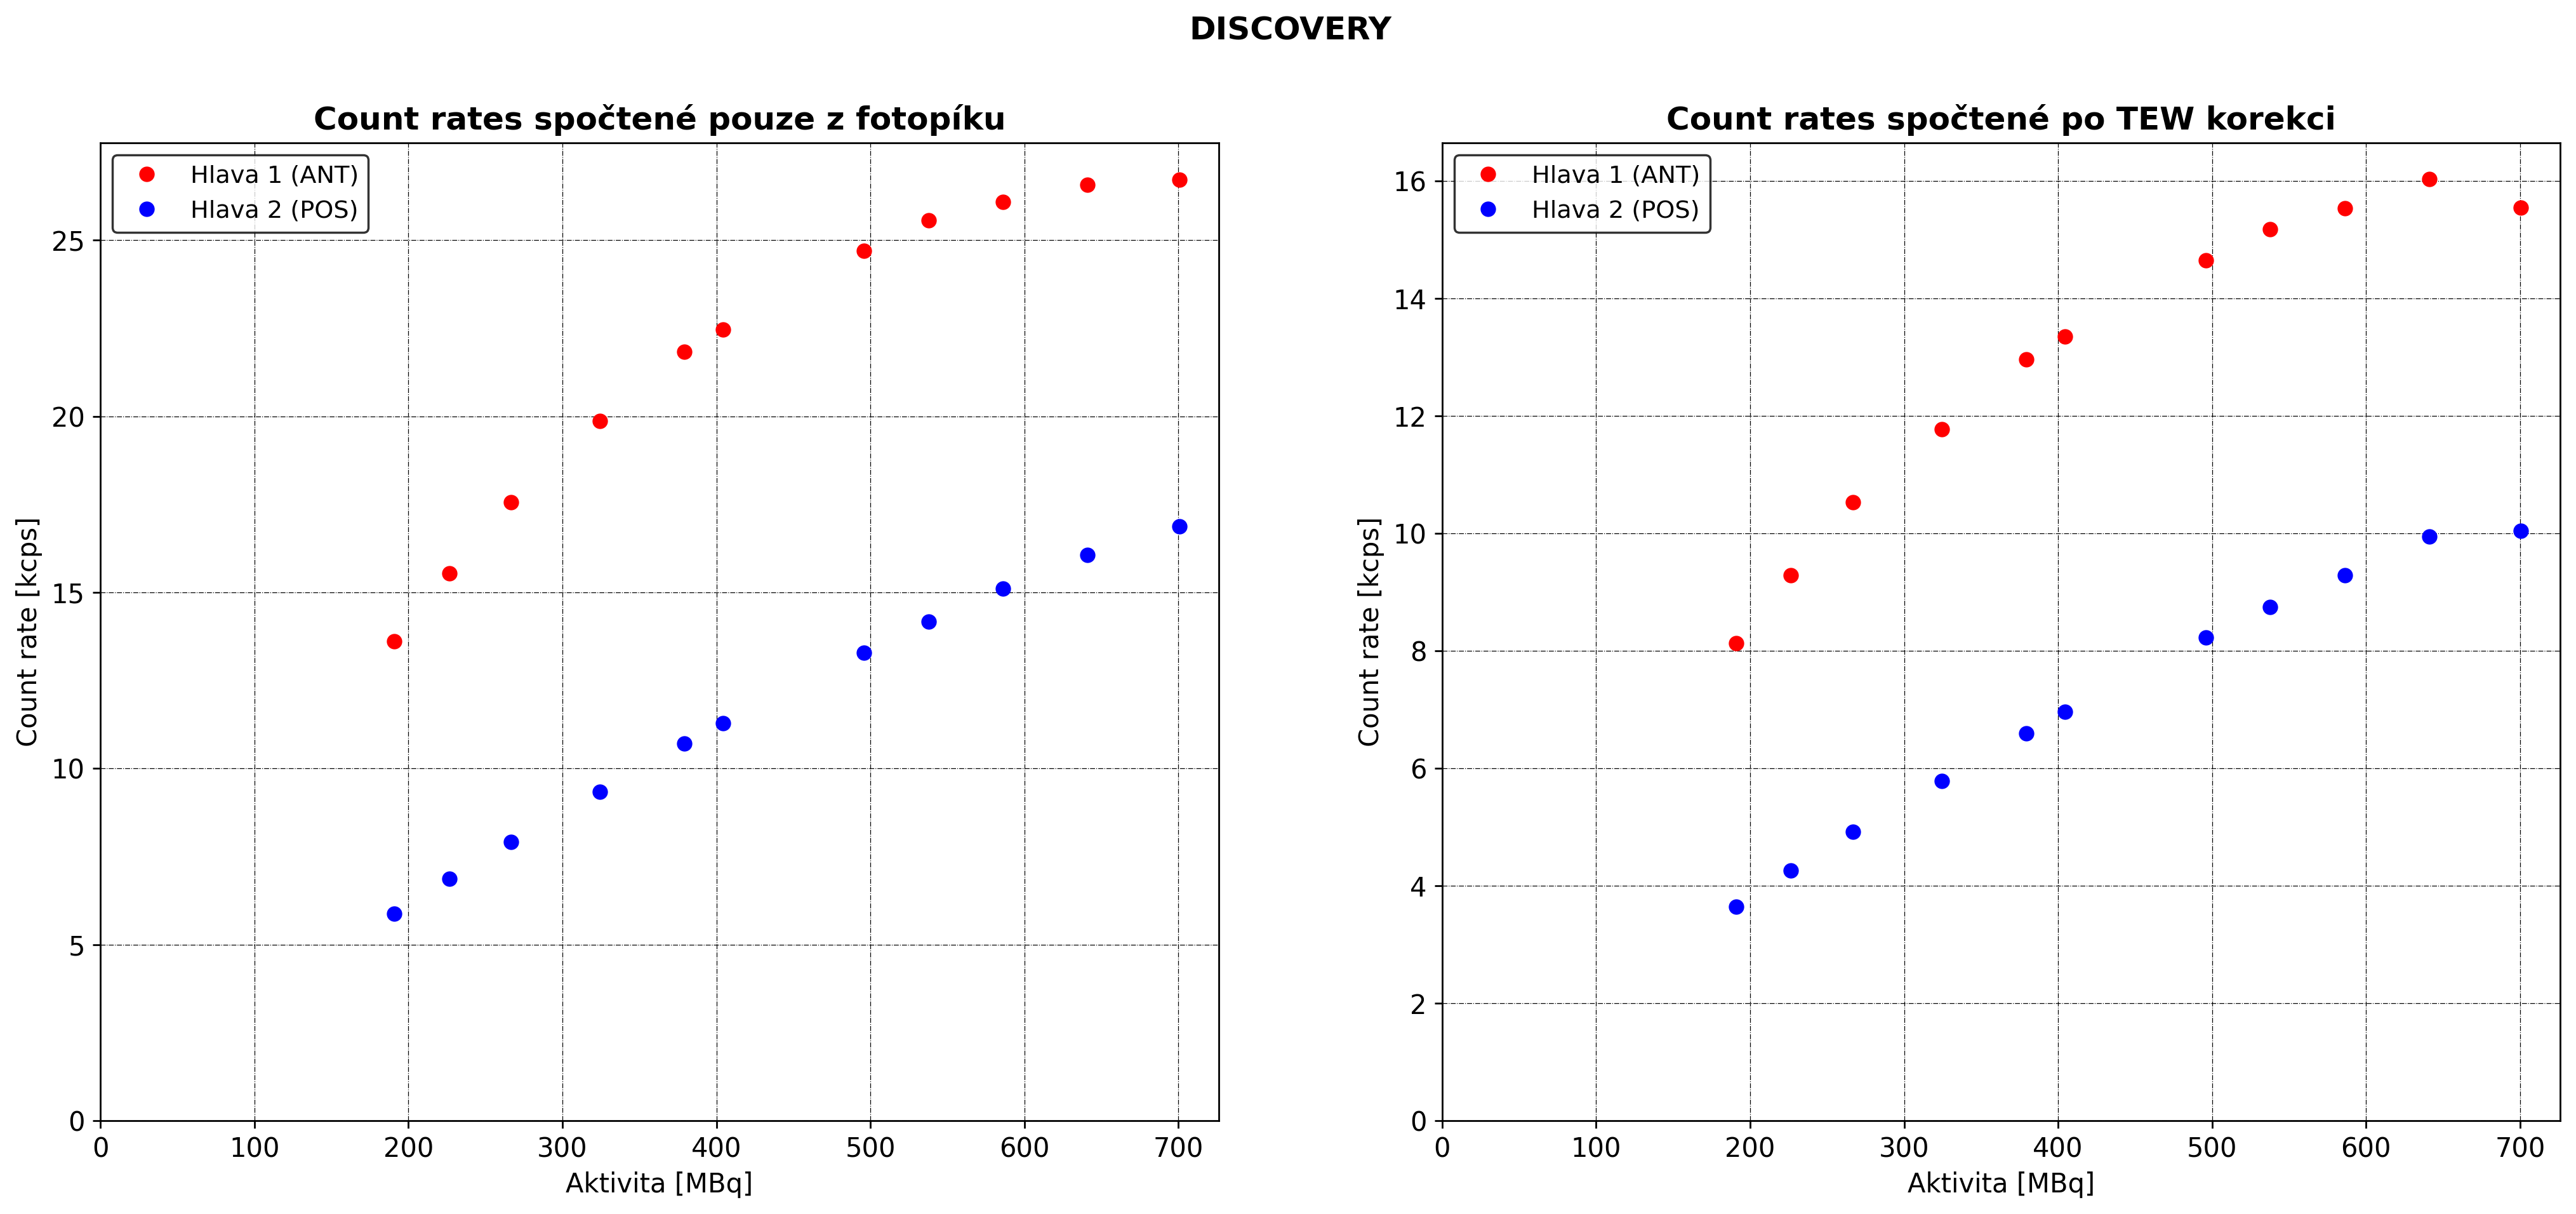

In [5]:
# DISCOVERY DATA mrtve doby

from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
import numpy as np



discovery_folder = 'Discovery'
discovery_mds = sorted(glob(os.path.join(discovery_folder, 'MD*')))
print(discovery_mds)

# je nutne si preddefinovat obrazek predem
dt_fig = Graf_1_2(12, "DISCOVERY",
               "Count rates spočtené pouze z fotopíku", "Aktivita [MBq]", "Count rate [kcps]",
               "Count rates spočtené po TEW korekci", "Aktivita [MBq]", "Count rate [kcps]",
               (20, 8))

# arraye pro doplňování Countrates
cr_1_no_corr_array = []
cr_2_no_corr_array = []
cr_1_tew_corr_array = []
cr_2_tew_corr_array = []

for md in discovery_mds:
    ### nejprve rozhazeni jednotlivych dat
    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]

    dt_data = separate_dicom_file(dead_time_path)
    bg_data = separate_dicom_file(pozadi_path)

    dt_acq_time = dt_data["Acq_time"]
    bg_acq_time = bg_data["Acq_time"]
    datum = dt_data["Acq_date"]
    aktivita = aktivity[datum]

    dt_1_no_corr = dt_data["Head1_EM"]
    bg_1_no_corr = bg_data["Head1_EM"]

    dt_1_tew_corr = tew_correction(dt_data["Head1_EM"], dt_data["Head1_SC1"], dt_data["Head1_SC2"])
    bg_1_tew_corr = tew_correction(bg_data["Head1_EM"], bg_data["Head1_SC1"], bg_data["Head1_SC2"])

    dt_2_no_corr = dt_data["Head2_EM"]
    bg_2_no_corr = bg_data["Head2_EM"]
    
    dt_2_tew_corr = tew_correction(dt_data["Head2_EM"], dt_data["Head2_SC1"], dt_data["Head2_SC2"])
    bg_2_tew_corr = tew_correction(bg_data["Head2_EM"], bg_data["Head2_SC1"], bg_data["Head2_SC2"])

    ### ----
    ### vypocty count rates

    cr_1_no_corr = np.sum(dt_1_no_corr)/dt_acq_time - np.sum(bg_1_no_corr)/bg_acq_time
    cr_1_no_corr_array.append(cr_1_no_corr*0.001)

    cr_2_no_corr = np.sum(dt_2_no_corr)/dt_acq_time - np.sum(bg_2_no_corr)/bg_acq_time
    cr_2_no_corr_array.append(cr_2_no_corr*0.001)

    cr_1_tew_corr = np.sum(dt_1_tew_corr)/dt_acq_time - np.sum(bg_1_tew_corr)/bg_acq_time
    cr_1_tew_corr_array.append(cr_1_tew_corr*0.001)

    cr_2_tew_corr = np.sum(dt_2_tew_corr)/dt_acq_time - np.sum(bg_2_tew_corr)/bg_acq_time
    cr_2_tew_corr_array.append(cr_2_tew_corr*0.001)

### ----
### vyploteni do obrazku
dt_fig.fig[0].plot(aktivity.values(), cr_1_no_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[0].plot(aktivity.values(), cr_2_no_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[0].set_xlim(0,None)
dt_fig.fig[0].set_ylim(0,None)

dt_fig.fig[1].plot(aktivity.values(), cr_1_tew_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[1].plot(aktivity.values(), cr_2_tew_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[1].set_xlim(0,None)
dt_fig.fig[1].set_ylim(0,None)

dt_fig.Figure.savefig(os.path.join(discovery_folder, 'grafy_mrtve_doby_Discovery.jpg'), bbox_inches = "tight")


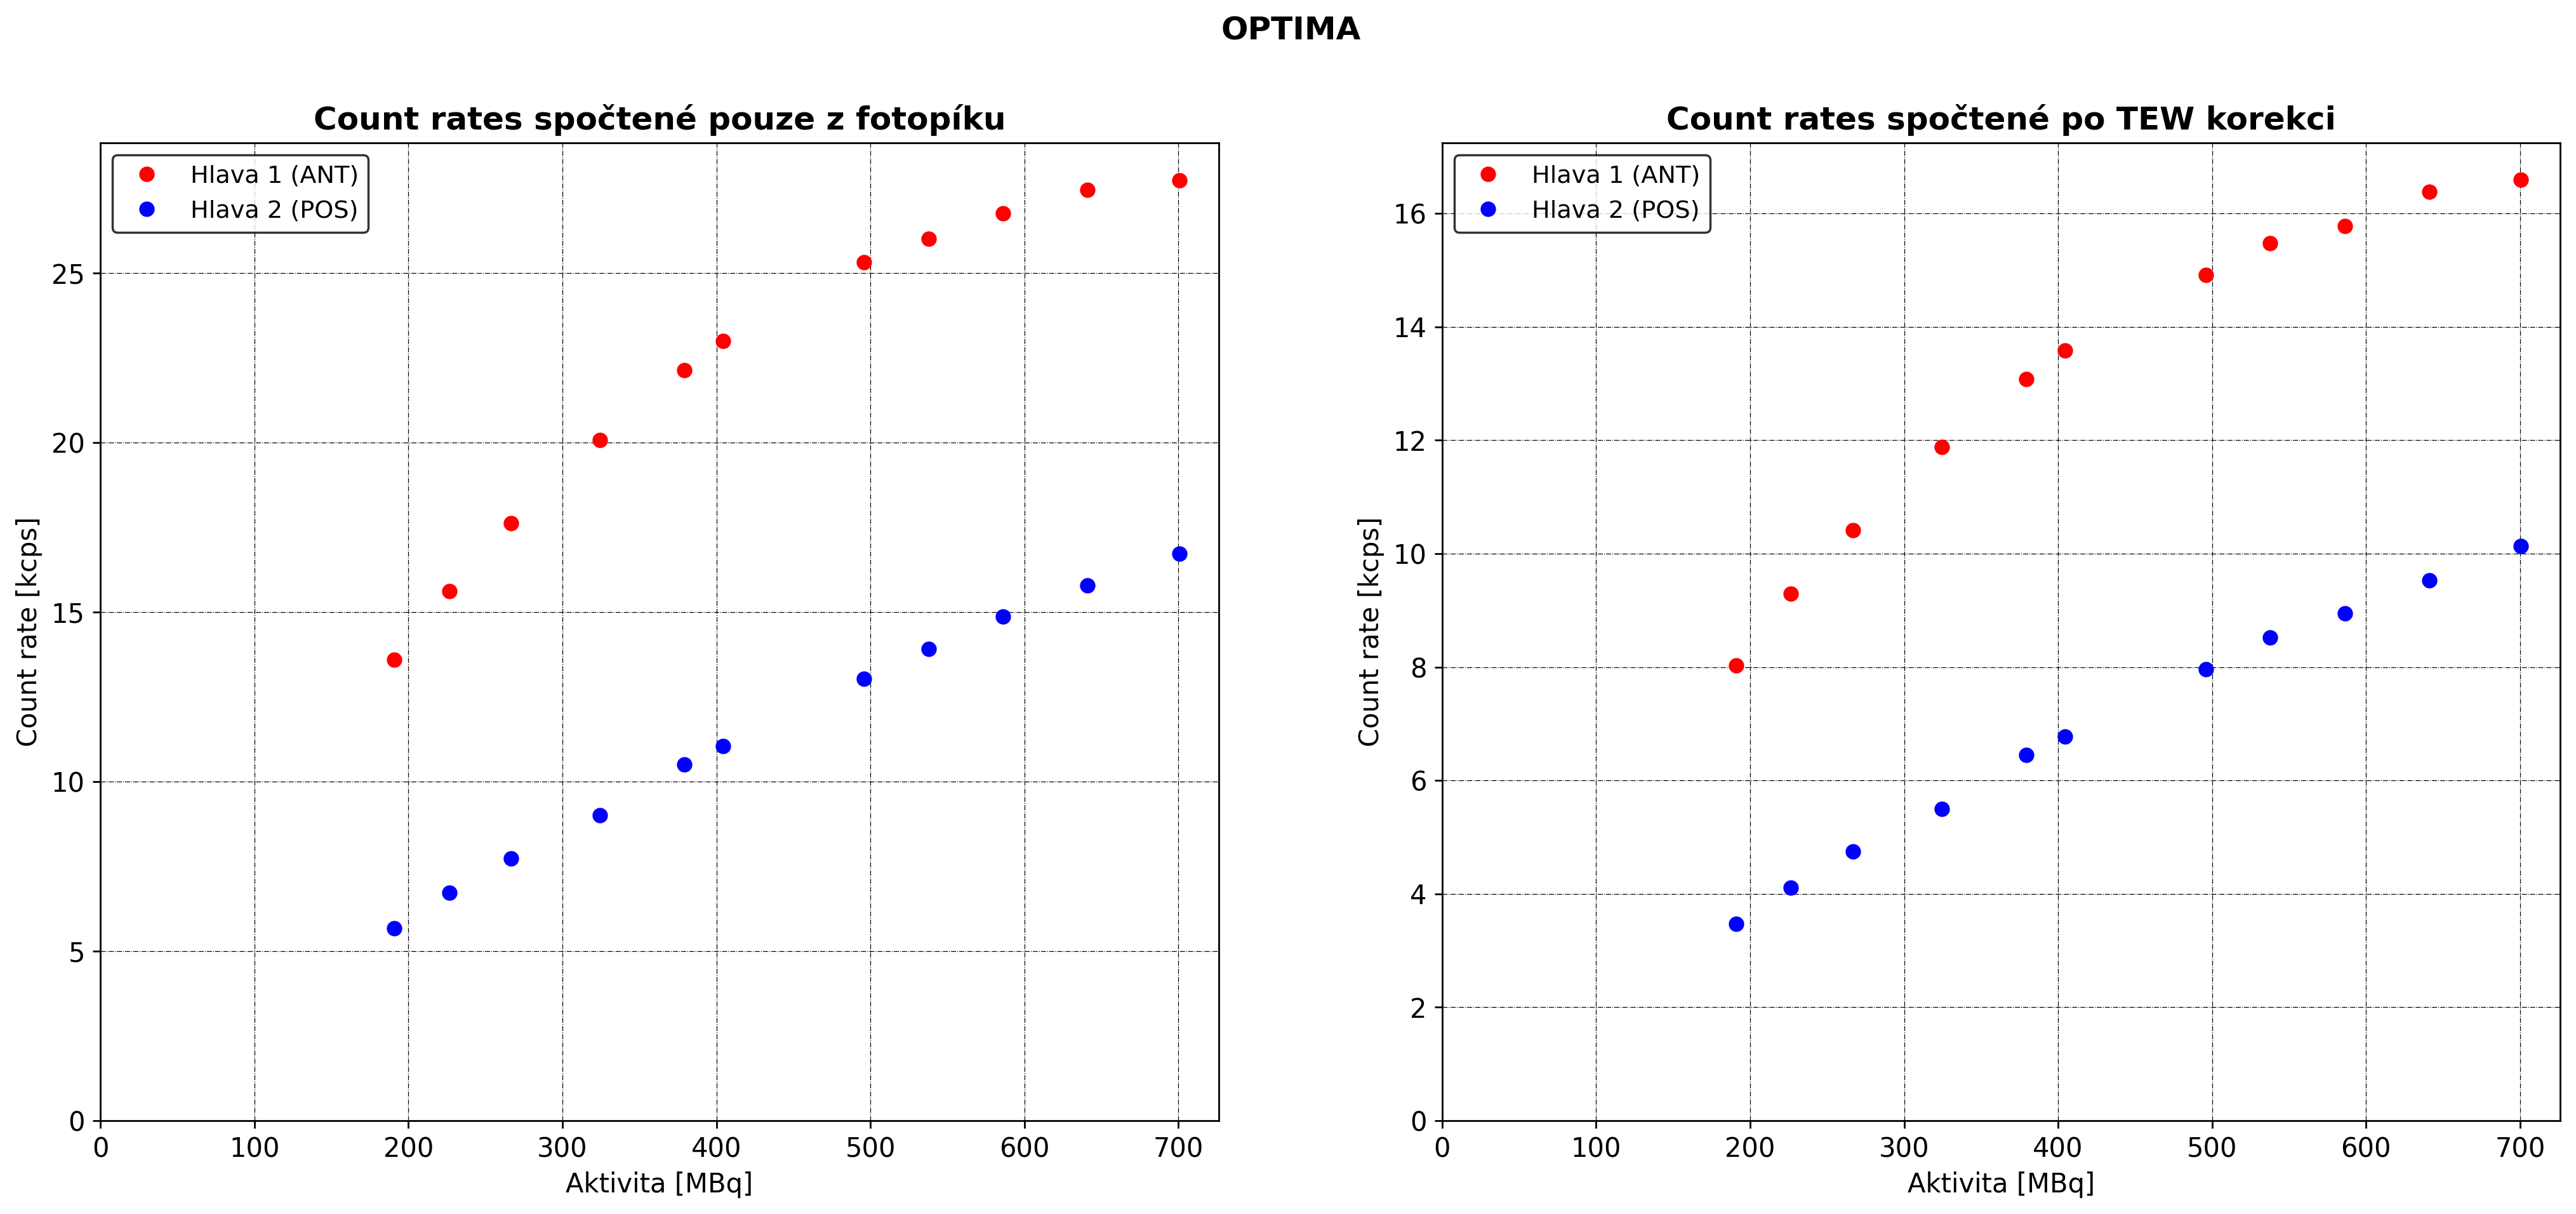

In [6]:
# OPTIMA DATA mrtve doby

from dicom_file_separator import separate_dicom_file
from tew_correction import tew_correction
import numpy as np



optima_folder = 'Optima'
optima_mds = sorted(glob(os.path.join(optima_folder, 'MD*')))

# je nutne si preddefinovat obrazek predem
dt_fig = Graf_1_2(12, "OPTIMA",
               "Count rates spočtené pouze z fotopíku", "Aktivita [MBq]", "Count rate [kcps]",
               "Count rates spočtené po TEW korekci", "Aktivita [MBq]", "Count rate [kcps]",
               (20, 8))

# arraye pro doplňování Countrates
cr_1_no_corr_array = []
cr_2_no_corr_array = []
cr_1_tew_corr_array = []
cr_2_tew_corr_array = []

for md in optima_mds:
    ### nejprve rozhazeni jednotlivych dat
    dead_time_path = glob(os.path.join(md, 'MD_*.dcm'))[0]
    pozadi_path = glob(os.path.join(md, 'Pozadi_*.dcm'))[0]

    dt_data = separate_dicom_file(dead_time_path)
    bg_data = separate_dicom_file(pozadi_path)

    dt_acq_time = dt_data["Acq_time"]
    bg_acq_time = bg_data["Acq_time"]
    datum = dt_data["Acq_date"]
    aktivita = aktivity[datum]

    dt_1_no_corr = dt_data["Head1_EM"]
    bg_1_no_corr = bg_data["Head1_EM"]

    dt_1_tew_corr = tew_correction(dt_data["Head1_EM"], dt_data["Head1_SC1"], dt_data["Head1_SC2"])
    bg_1_tew_corr = tew_correction(bg_data["Head1_EM"], bg_data["Head1_SC1"], bg_data["Head1_SC2"])

    dt_2_no_corr = dt_data["Head2_EM"]
    bg_2_no_corr = bg_data["Head2_EM"]
    
    dt_2_tew_corr = tew_correction(dt_data["Head2_EM"], dt_data["Head2_SC1"], dt_data["Head2_SC2"])
    bg_2_tew_corr = tew_correction(bg_data["Head2_EM"], bg_data["Head2_SC1"], bg_data["Head2_SC2"])

    ### ----
    ### vypocty count rates

    cr_1_no_corr = np.sum(dt_1_no_corr)/dt_acq_time - np.sum(bg_1_no_corr)/bg_acq_time
    cr_1_no_corr_array.append(cr_1_no_corr*0.001)

    cr_2_no_corr = np.sum(dt_2_no_corr)/dt_acq_time - np.sum(bg_2_no_corr)/bg_acq_time
    cr_2_no_corr_array.append(cr_2_no_corr*0.001)

    cr_1_tew_corr = np.sum(dt_1_tew_corr)/dt_acq_time - np.sum(bg_1_tew_corr)/bg_acq_time
    cr_1_tew_corr_array.append(cr_1_tew_corr*0.001)

    cr_2_tew_corr = np.sum(dt_2_tew_corr)/dt_acq_time - np.sum(bg_2_tew_corr)/bg_acq_time
    cr_2_tew_corr_array.append(cr_2_tew_corr*0.001)

### ----
### vyploteni do obrazku
dt_fig.fig[0].plot(aktivity.values(), cr_1_no_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[0].plot(aktivity.values(), cr_2_no_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[0].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[0].set_xlim(0,None)
dt_fig.fig[0].set_ylim(0,None)

dt_fig.fig[1].plot(aktivity.values(), cr_1_tew_corr_array, "o", color = "red", label = "Hlava 1 (ANT)")
dt_fig.fig[1].plot(aktivity.values(), cr_2_tew_corr_array, "o", color = "blue", label = "Hlava 2 (POS)")
dt_fig.fig[1].legend(loc = 'best', edgecolor = 'black', fontsize = 11)
dt_fig.fig[1].set_xlim(0,None)
dt_fig.fig[1].set_ylim(0,None)

dt_fig.Figure.savefig(os.path.join(optima_folder, 'grafy_mrtve_doby_Optima.jpg'), bbox_inches = "tight")